In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import words
from tqdm import tqdm
import nltk

def generate_word_image_dataset(num_words=100000, image_width=256, image_height=64):

    try:
        nltk.data.find('corpora/words')
    except LookupError:
        nltk.download('words')
    
    word_list = words.words()
    if len(word_list) < num_words:
        raise ValueError(f"Requested {num_words} words but only {len(word_list)} available")
    
    selected_words = np.random.choice(word_list, size=num_words, replace=False)
    
 
    font = ImageFont.load_default(32)
    
    image_array = np.zeros((num_words, image_height, image_width, 3), dtype=np.uint8)
    
    for idx, word in enumerate(tqdm(selected_words, desc="Generating word images")):

        image = Image.new('RGB', (image_width, image_height), color='white')
        draw = ImageDraw.Draw(image)
        
        bbox = draw.textbbox((0, 0), word, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        x = (image_width - text_width) // 2
        y = (image_height - text_height) // 2
        
        draw.text((x, y), word, fill='black', font=font)
        
        image_array[idx] = np.array(image)
    
    return image_array, selected_words.tolist()

images, words = generate_word_image_dataset(num_words=100000)

Generating word images: 100%|██████████| 100000/100000 [00:48<00:00, 2079.86it/s]


 imageShape  = (100000, 64, 256, 3)
 SampleWords  = ['primer', 'Nephropsidae', 'diving', 'unmomentous', 'starnel']

First word primer
First image shape (64, 256, 3)


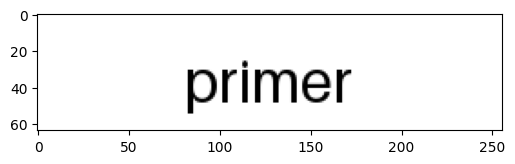

In [3]:
import matplotlib.pyplot as plt

print(f" imageShape  = {images.shape}")
print(f" SampleWords  = {words[:5]}")

print(f"\nFirst word {words[0]}")
print(f"First image shape {images[0].shape}")

plt.figure(figsize = [6,6])
plt.imshow(images[0])

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


letter_to_number = {chr(i): i - 96 for i in range(97, 123)}

def convert_word_to_numeric_labels(word):
    return [letter_to_number[letter] for letter in word.lower() if letter in letter_to_number]

print(words[0])

label_test = convert_word_to_numeric_labels(words[0])
print(label_test)

primer
[16, 18, 9, 13, 5, 18]


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class WordImageDataset(Dataset):
    def __init__(self, images, words, img_height=64, img_width=256):
        self.images = images
        self.words = words
        self.img_height = img_height
        self.img_width = img_width
        
        unique_chars = sorted(set(''.join(words)))
        self.CHAR2LABEL = {char: i + 1 for i, char in enumerate(unique_chars)}
        self.LABEL2CHAR = {label: char for char, label in self.CHAR2LABEL.items()}
        self.LABEL2CHAR[0] = ''  
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        word = self.words[idx]
        
        image = np.mean(image, axis=2).astype(np.float32)
        
        image = (image - 127.5) / 127.5
        
        image = torch.FloatTensor(image).unsqueeze(0)
        
        label = [self.CHAR2LABEL[c] for c in word]
        
        return image, torch.LongTensor(label)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    
    lengths = [len(label) for label in labels]
    
    max_length = max(lengths)
    padded_labels = []
    for label in labels:
        padded = torch.nn.functional.pad(label, (0, max_length - len(label)), value=0)
        padded_labels.append(padded)
    
    labels = torch.stack(padded_labels)
    lengths = torch.LongTensor(lengths)
    
    return images, labels, lengths

def create_data_loaders(images, words, batch_size=32, train_split=0.7, val_split=0.15):
    """
    Split data into train, validation, and test sets.
    train_split = 70%, val_split = 15%, test_split = 15%
    """
    num_samples = len(images)
    indices = np.random.permutation(num_samples)
    
    # Calculate split points
    train_size = int(train_split * num_samples)
    val_size = int(val_split * num_samples)
    
    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Split data
    train_images = images[train_indices]
    train_words = [words[i] for i in train_indices]
    
    val_images = images[val_indices]
    val_words = [words[i] for i in val_indices]
    
    test_images = images[test_indices]
    test_words = [words[i] for i in test_indices]
    
    # Create datasets
    train_dataset = WordImageDataset(train_images, train_words)
    val_dataset = WordImageDataset(val_images, val_words)
    test_dataset = WordImageDataset(test_images, test_words)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    return train_loader, val_loader, test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader = create_data_loaders(images, words, batch_size=32)

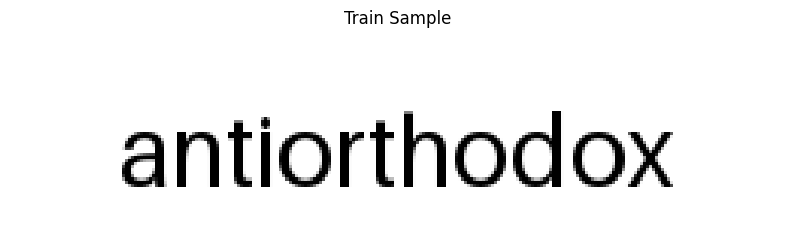

Train Label Text: antiorthodox
Train Label Numbers: [ 1 14 20  9 15 18 20  8 15  4 15 24]


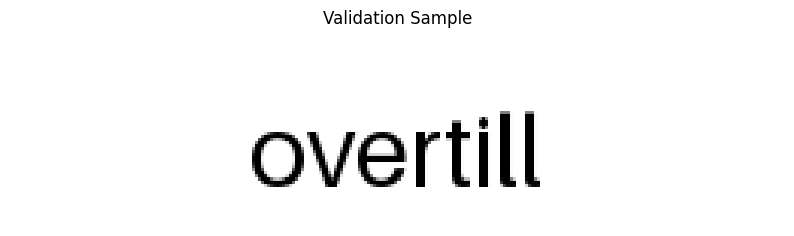

Validation Label Text: overtill
Validation Label Numbers: [15 22  5 18 20  9 12 12]


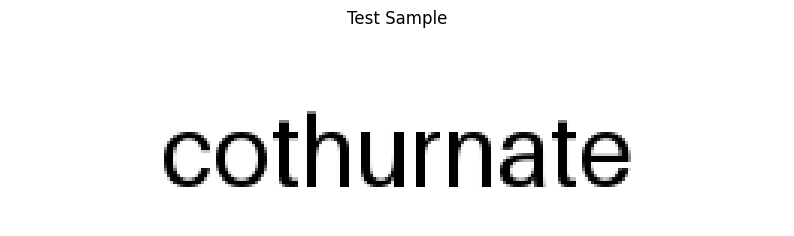

Test Label Text: cothurnate
Test Label Numbers: [ 3 15 20  8 21 18 14  1 20  5]


In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np

class WordImageDataset(Dataset):
    def __init__(self, images, words, img_height=64, img_width=256):
        self.images = images
        self.words = words
        self.img_height = img_height
        self.img_width = img_width
        
        self.CHAR2LABEL = {
            'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5,
            'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10,
            'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15,
            'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20,
            'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25,
            'z': 26
        }
        
        self.LABEL2CHAR = {
            0: '',  # blank token
            1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
            6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j',
            11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o',
            16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't',
            21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y',
            26: 'z'
        }
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        word = self.words[idx].lower()  # Convert to lowercase
        
        image = np.mean(image, axis=2).astype(np.float32)
        image = (image - 127.5) / 127.5
        image = torch.FloatTensor(image).unsqueeze(0)
        
        label = [self.CHAR2LABEL[c] for c in word]
        
        return image, torch.LongTensor(label)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    
    lengths = [len(label) for label in labels]
    max_length = max(lengths)
    
    padded_labels = []
    for label in labels:
        padded = torch.nn.functional.pad(label, (0, max_length - len(label)), value=0)
        padded_labels.append(padded)
    
    labels = torch.stack(padded_labels)
    lengths = torch.LongTensor(lengths)
    
    return images, labels, lengths

def create_data_loaders(images, words, batch_size=32, train_split=0.7, val_split=0.15):
    num_samples = len(images)
    indices = np.random.permutation(num_samples)
    
    train_size = int(train_split * num_samples)
    val_size = int(val_split * num_samples)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_images = images[train_indices]
    train_words = [words[i] for i in train_indices]
    
    val_images = images[val_indices]
    val_words = [words[i] for i in val_indices]
    
    test_images = images[test_indices]
    test_words = [words[i] for i in test_indices]
    
    train_dataset = WordImageDataset(train_images, train_words)
    val_dataset = WordImageDataset(val_images, val_words)
    test_dataset = WordImageDataset(test_images, test_words)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    return train_loader, val_loader, test_loader

def visualize_sample(loader, dataset_name):
    for images, labels, lengths in loader:
        image = images[0].squeeze(0).numpy()
        label = labels[0].numpy()[:lengths[0]]
        
        plt.figure(figsize=(10, 3))
        plt.imshow(image, cmap='gray')
        plt.title(f"{dataset_name} Sample")
        plt.axis('off')
        plt.show()
        
        decoded_text = ''.join([loader.dataset.LABEL2CHAR[l] for l in label])
        print(f"{dataset_name} Label Text: {decoded_text}")
        print(f"{dataset_name} Label Numbers: {label}")
        break

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader = create_data_loaders(images, words, batch_size=32)

visualize_sample(train_loader, "Train")
visualize_sample(val_loader, "Validation")
visualize_sample(test_loader, "Test")

Image shape: torch.Size([32, 1, 64, 256])
Output shape: torch.Size([32, 64, 27])
Predicted sequence: tensor([ 6,  6, 23, 23,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6], device='cuda:0')
Predicted sequence shape: torch.Size([64])
Word label being:  [ 4  5 13 15 14  9  1 14]


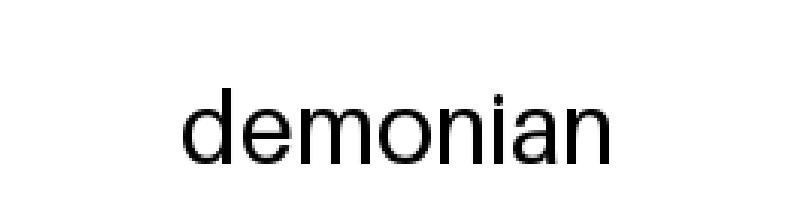

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

class CRNN(nn.Module):
    def __init__(self, img_channel, img_height, img_width, num_chars):
        super(CRNN, self).__init__()
        # Initial input: [batch, 1, 64, 256]
        self.conv_1 = nn.Conv2d(img_channel, 128, kernel_size=(3, 3), padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        # After conv1 + pool1: [batch, 128, 32, 128]
        
        self.conv_2 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
        # After conv2 + pool2: [batch, 256, 16, 64]
        
        self.conv_3 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
        self.pool_3 = nn.MaxPool2d(kernel_size=(2, 1))  # Note: pooling only height
        # After conv3 + pool3: [batch, 512, 8, 64]
        
        self.conv_4 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1))
        self.pool_4 = nn.MaxPool2d(kernel_size=(2, 1))  # Note: pooling only height
        # After conv4 + pool4: [batch, 512, 4, 64]
        
        self.linear_1 = nn.Linear(512 * 4, 64)  # 512 channels * 4 height
        self.drop_1 = nn.Dropout(0.2)
        # After linear + dropout: [batch, 64, 64]
        
        self.rnn = nn.RNN(64, 128, bidirectional=True, num_layers=2, dropout=0.2, batch_first=True)
        # After RNN: [batch, 64, 256]
        
        self.output = nn.Linear(256, num_chars)
        # Final output: [batch, sequence_length, num_chars]

    def forward(self, images):
        bs, _, _, _ = images.size()
#         print(f"Input shape: {images.shape}")  # [batch, 1, 64, 256]
        
        x = F.relu(self.conv_1(images))
        x = self.pool_1(x)
#         print(f"After conv1 + pool1: {x.shape}")  # [batch, 128, 32, 128]
        
        x = F.relu(self.conv_2(x))
        x = self.pool_2(x)
#         print(f"After conv2 + pool2: {x.shape}")  # [batch, 256, 16, 64]
        
        x = F.relu(self.conv_3(x))
        x = self.pool_3(x)
#         print(f"After conv3 + pool3: {x.shape}")  # [batch, 512, 8, 64]
        
        x = F.relu(self.conv_4(x))
        x = self.pool_4(x)
#         print(f"After conv4 + pool4: {x.shape}")  # [batch, 512, 4, 64]
        
        # Reshape for sequence processing
        x = x.permute(0, 3, 1, 2)  # [batch, 64, 512, 4]
        x = x.view(bs, x.size(1), -1)  # [batch, 64, 2048]
        
        x = F.relu(self.linear_1(x))
        x = self.drop_1(x)
#         print(f"After linear + dropout: {x.shape}")  # [batch, 64, 64]
        
        x, _ = self.rnn(x)
#         print(f"After RNN: {x.shape}")  # [batch, 64, 256]
        
        x = self.output(x)
#         print(f"Final output: {x.shape}")  # [batch, 64, num_chars]
        
        return x

if __name__ == "__main__":
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     device = 'cpu'
    model = CRNN(1, 64, 256, 27).to(device)
    model.eval()
    
    for images, labels, lengths in train_loader:

        images = images.to(device)
        labels = labels[0].numpy()[:lengths[0]]
        
        with torch.no_grad(): 
            output = model(images) 
        
        print("Image shape:", images.shape)
        print("Output shape:", output.shape)
        
        predicted_sequence = output[0].argmax(1)  
        print("Predicted sequence:", predicted_sequence)
        print("Predicted sequence shape:", predicted_sequence.shape)
        print("Word label being: ", labels)
        
        img_to_show = images[0].cpu()  
        
        if img_to_show.shape[0] == 1:
            img_to_show = img_to_show.squeeze(0)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(img_to_show.numpy(), cmap='gray') 
        plt.axis('off')  
        plt.show()
        break
        

In [7]:
def train_model(model, train_loader, val_loader, num_epochs, device, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True, reduction='mean')
    model = model.to(device)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        for images, labels, lengths in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass with gradient computation
            output = model(images)
            log_probs = F.log_softmax(output, dim=2)
            log_probs = log_probs.permute(1, 0, 2)  # (T, N, C)
            
            # Get sequence lengths
            input_lengths = torch.full(
                size=(images.size(0),),
                fill_value=log_probs.size(0),
                dtype=torch.long
            ).to(device)
            
            target_lengths = lengths.to(device).long()
            
            # Compute loss
            loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Add gradient clipping
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
        
        avg_train_loss = train_loss / batch_count
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for images, labels, lengths in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                output = model(images)
                log_probs = F.log_softmax(output, dim=2)
                log_probs = log_probs.permute(1, 0, 2)
                
                input_lengths = torch.full(
                    size=(images.size(0),),
                    fill_value=log_probs.size(0),
                    dtype=torch.long
                ).to(device)
                
                target_lengths = lengths.to(device).long()
                
                loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)
                val_loss += loss.item()
                val_batch_count += 1
        
        avg_val_loss = val_loss / val_batch_count
        
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
    
    return model

def calculate_accuracy(model, test_loader, device):
    
    model.eval()
    correct = 0
    total = 0
    total_correct_chars = 0
    total_chars = 0
    
    with torch.no_grad():
        for images, labels, lengths in test_loader:
            images = images.to(device)
            batch_size = images.size(0)
            
            # Forward pass
            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)
            
            # Decode predictions
            for batch_idx in range(batch_size):
                # Get prediction for this sample
                pred_sequence = log_probs[batch_idx].argmax(dim=1).cpu().numpy()
                
                # Merge repeated characters and remove blanks (CTC decoding)
                pred_chars = []
                previous = -1
                for p in pred_sequence:
                    if p != 0 and p != previous:  # Skip blanks and repeats
                        pred_chars.append(test_loader.dataset.LABEL2CHAR[p])
                    previous = p
                
                predicted_string = ''.join(pred_chars)
                
                # Get ground truth
                true_length = lengths[batch_idx].item()
                true_indices = labels[batch_idx, :true_length].cpu().numpy()
                true_chars = [test_loader.dataset.LABEL2CHAR[idx] for idx in true_indices]
                true_string = ''.join(true_chars)
                
                # Calculate character-level accuracy
                min_len = min(len(predicted_string), len(true_string))
                correct_chars = sum(1 for i in range(min_len) 
                                  if predicted_string[i] == true_string[i])
                total_correct_chars += correct_chars
                total_chars += max(len(predicted_string), len(true_string))
                
                # Calculate sequence-level accuracy
                if predicted_string == true_string:
                    correct += 1
                total += 1
                
                # Print first few examples
                if total <= 5:  # Show first 5 examples
                    print(f"\nSample {total}:")
                    print(f"Predicted: '{predicted_string}'")
                    print(f"True     : '{true_string}'")
                    print(f"Correct chars: {correct_chars}/{max(len(predicted_string), len(true_string))}")
                    print(f"Exact match: {'Yes' if predicted_string == true_string else 'No'}")
    
    sequence_accuracy = (correct / total) * 100 if total > 0 else 0
    char_accuracy = (total_correct_chars / total_chars) * 100 if total_chars > 0 else 0
    
    return sequence_accuracy, correct, total, char_accuracy, total_correct_chars, total_chars


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(1, 64, 256, num_chars=len(train_loader.dataset.CHAR2LABEL) + 1).to(device)

num_epochs = 5
lr = 1e-3
trained_model = train_model(model, train_loader, val_loader, num_epochs, device, lr=lr)

Epoch 1/5, Train Loss: 0.3922, Validation Loss: 0.0137
Epoch 2/5, Train Loss: 0.0133, Validation Loss: 0.0087
Epoch 3/5, Train Loss: 0.0092, Validation Loss: 0.0069
Epoch 4/5, Train Loss: 0.0076, Validation Loss: 0.0067
Epoch 5/5, Train Loss: 0.0068, Validation Loss: 0.0063


In [8]:
def remove_consecutive_duplicates(input_string):

    if len(input_string) < 2:
        return input_string
        
    result = [input_string[0]] 
    
    for i in range(1, len(input_string)):

        if input_string[i] != input_string[i-1]:
            result.append(input_string[i])
                
    return ''.join(result)

i = 0
for images, labels, lengths in train_loader:

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        output = model(images)  

    print("Image shape:", images.shape) 
    print("Output shape:", output.shape)  

    log_probs = F.log_softmax(output, dim=2)
    predicted_sequence = log_probs.argmax(2)  
    predicted_sequence = predicted_sequence[0]  

    predicted_chars = [
        train_loader.dataset.LABEL2CHAR[idx.item()] for idx in predicted_sequence
    ]
    predicted_string = ''.join([char for char in predicted_chars if char != ' '])
    
    print("Predicted sequence shape:", predicted_sequence.shape)
    print("Predicted string:", predicted_string)
    
    predicted_string = remove_consecutive_duplicates(predicted_string)
    
    print("Predicted sequence shape:", predicted_sequence.shape)
    print("Predicted string:", predicted_string)

    if lengths.numel() > 0:
        true_label_indices = labels[0, :lengths[0]]  #
        true_label = ''.join(
            [train_loader.dataset.LABEL2CHAR[idx.item()] for idx in true_label_indices]
        )
        print("True label:", true_label)
    print('-------------------------------------------------------------------------------------')
    if i > 5:
        break
    i += 1

Image shape: torch.Size([32, 1, 64, 256])
Output shape: torch.Size([32, 64, 27])
Predicted sequence shape: torch.Size([64])
Predicted string: fauggh
Predicted sequence shape: torch.Size([64])
Predicted string: faugh
True label: faugh
-------------------------------------------------------------------------------------
Image shape: torch.Size([32, 1, 64, 256])
Output shape: torch.Size([32, 64, 27])
Predicted sequence shape: torch.Size([64])
Predicted string: ppeaker
Predicted sequence shape: torch.Size([64])
Predicted string: peaker
True label: peaker
-------------------------------------------------------------------------------------
Image shape: torch.Size([32, 1, 64, 256])
Output shape: torch.Size([32, 64, 27])
Predicted sequence shape: torch.Size([64])
Predicted string: ggripppping
Predicted sequence shape: torch.Size([64])
Predicted string: griping
True label: gripping
-------------------------------------------------------------------------------------
Image shape: torch.Size([32

In [ ]:
def calculate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_correct_chars = 0
    total_chars = 0
    
    with torch.no_grad():
        for images, labels, lengths in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            log_probs = F.log_softmax(output, dim=2)
            predicted_sequence = log_probs.argmax(2)[0]
            
            predicted_chars = [
                test_loader.dataset.LABEL2CHAR[idx.item()] 
                for idx in predicted_sequence
            ]
            predicted_string = ''.join([char for char in predicted_chars if char != ' '])
            predicted_string = remove_consecutive_duplicates(predicted_string)
            
            if lengths.numel() > 0:
                true_label_indices = labels[0, :lengths[0]]
                true_label = ''.join(
                    [test_loader.dataset.LABEL2CHAR[idx.item()] 
                     for idx in true_label_indices]
                )
                
                min_len = min(len(predicted_string), len(true_label))
                correct_chars = sum(1 for i in range(min_len) 
                                  if predicted_string[i] == true_label[i])
                total_correct_chars += correct_chars
                total_chars += max(len(predicted_string), len(true_label))
                
                if predicted_string == true_label:
                    correct += 1
                total += 1
                
            if total <= 5:
                print(f"\nPrediction: {predicted_string}")
                print(f"True Label: {true_label}")
                print(f"Correct Characters: {correct_chars}/{max(len(predicted_string), len(true_label))}")
                print("Exact Match:", "Yes" if predicted_string == true_label else "No")
                print("-" * 50)
    
    accuracy = (correct / total) * 100 if total > 0 else 0
    char_accuracy = (total_correct_chars / total_chars) * 100 if total_chars > 0 else 0
    
    return accuracy, correct, total, char_accuracy, total_correct_chars, total_chars

model.eval()
accuracy, correct, total, char_accuracy, correct_chars, total_chars = calculate_accuracy(model, test_loader, device)

print(f"\nResults on Test Set:")
print(f"Exact Match Accuracy: {accuracy:.2f}%")
print(f"Exact Matches: {correct}/{total}")
print(f"\nCharacter-Level Accuracy: {char_accuracy:.2f}%")
print(f"Correct Characters: {correct_chars}/{total_chars}")
print(f"Average Correct Characters per String: {correct_chars/total:.2f}")


Prediction: cothurnate
True Label: cothurnate
Correct Characters: 10/10
Exact Match: Yes
--------------------------------------------------

Prediction: claw
True Label: claw
Correct Characters: 4/4
Exact Match: Yes
--------------------------------------------------

Prediction: infraglotic
True Label: infraglottic
Correct Characters: 9/12
Exact Match: No
--------------------------------------------------

Prediction: gastrohypertonic
True Label: gastrohypertonic
Correct Characters: 16/16
Exact Match: Yes
--------------------------------------------------

Prediction: besprinkler
True Label: besprinkler
Correct Characters: 11/11
Exact Match: Yes
--------------------------------------------------

Results on Test Set:
Exact Match Accuracy: 77.40%
Exact Matches: 363/469

Character-Level Accuracy: 88.13%
Correct Characters: 4026/4568
Average Correct Characters per String: 8.58
